# Car Classifier 

**Purpose:** This notebook demonstrates a PyTorch workflow to classify car images. 

**Contents:**
1. Imports
2. Configuration
3. Data preparation 
4. Model definition
5. Training utilities 
6. Training loop 
7. Save / Load model 
8. Evaluation 
9. Next steps


## Imports

In [8]:
import os
from pathlib import Path
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

import PIL.Image as Image
from IPython.display import display

from preprocessing import cfg, build_train_transforms, build_test_transforms, build_datasets, build_dataloaders

# load config.json
cfg = cfg
print(cfg)
train_dir = cfg.train_dir
test_dir = cfg.test_dir

# deterministic behavior for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print(torch.cuda.get_device_name(device))

Config(seed=42, data_dir='./input/car_data/car_data', train_dir='./input/car_data/car_data\\train', test_dir='./input/car_data/car_data\\test', img_size=400, batch_size=32, num_workers=2, lr=0.01, weight_decay=0.0001, epochs=10, model_dir='models', model_name='car_classifier_resnet34.pth', normalize_mean=(0.5, 0.5, 0.5), normalize_std=(0.5, 0.5, 0.5), horizontal_flip=True, rotation_deg=15, pin_memory=True)
Device: cuda
NVIDIA GeForce RTX 5070 Ti


In [9]:
# Reproducibility
import random
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(cfg.seed)

## Pipeline

In [10]:
# load pipeline from "./preprocessing.py"

train_tf = build_train_transforms(cfg)
test_tf  = build_test_transforms(cfg)

datasets_dict = build_datasets(cfg)
loaders = build_dataloaders(datasets_dict, cfg)

train_dataset = datasets_dict["train"]
test_dataset = datasets_dict["test"]

train_loader = loaders["train"]
test_loader = loaders["test"]

class_names = train_dataset.classes
num_classes = len(class_names)
print('Classes:', class_names)
print('Train samples:', len(train_dataset), '\nTest samples:', len(test_dataset))

Classes: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Convert

## Exploratory Data Analysis

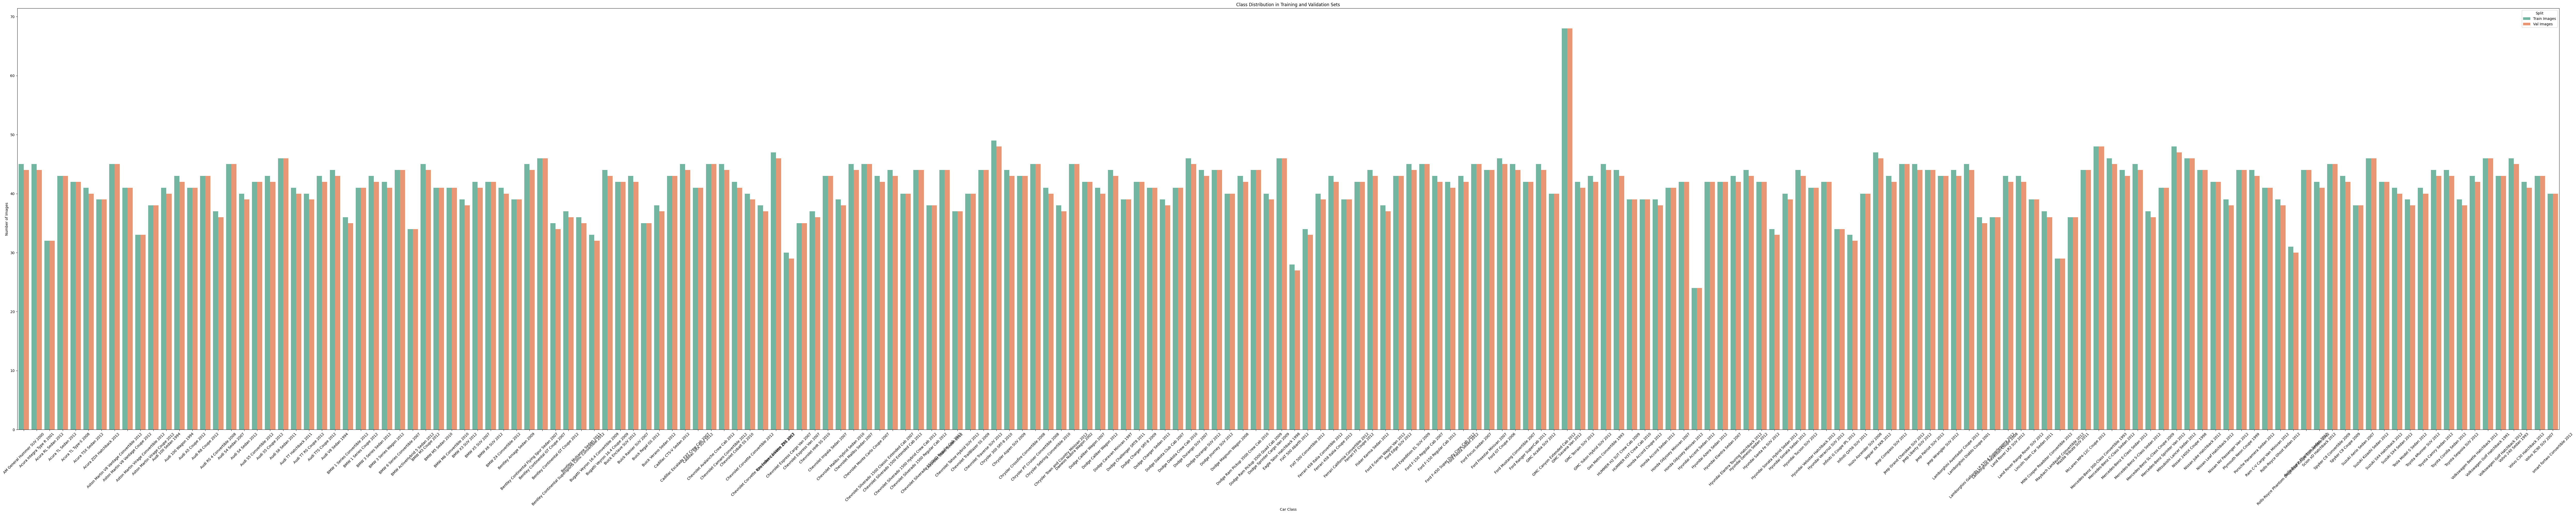

In [11]:
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
val_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in class_names}

train_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Train Images'])
val_df = pd.DataFrame(list(val_counts.items()), columns=['Class', 'Val Images'])
dist_df = pd.merge(train_df, val_df, on='Class')

# Plot distribution
plt.figure(figsize=(100, 20))
sns.barplot(data=dist_df.melt(id_vars='Class', var_name='Split', value_name='Count'),
            x='Class', y='Count', hue='Split', palette='Set2')
plt.title("Class Distribution in Training and Validation Sets")
plt.xlabel("Car Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

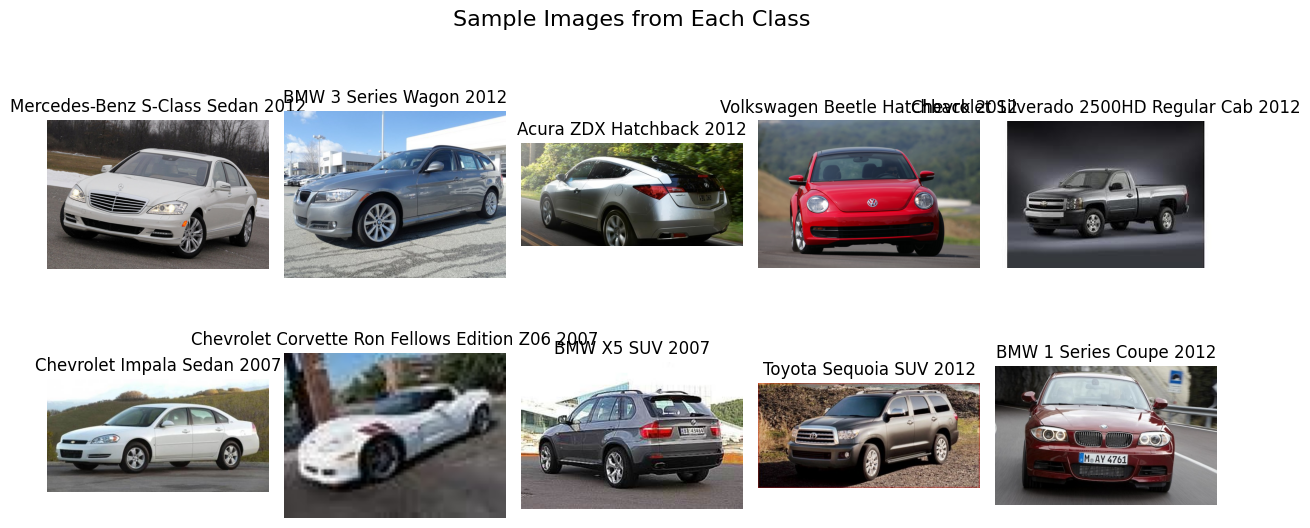

In [12]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Sample Images from Each Class", fontsize=16)
for i, cls in enumerate(random.sample(class_names, min(10, len(class_names)))):
    img_path = os.path.join(train_dir, cls, random.choice(os.listdir(os.path.join(train_dir, cls))))
    img = Image.open(img_path)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [13]:
transform_stats = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

sample_dataset = datasets.ImageFolder(train_dir, transform=transform_stats)
loader = DataLoader(sample_dataset, batch_size=128, shuffle=True)

mean, std = 0., 0.
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(sample_dataset)
std /= len(sample_dataset)

print(f"Dataset mean: {mean}")
print(f"Dataset std: {std}")

Dataset mean: tensor([0.4707, 0.4602, 0.4550])
Dataset std: tensor([0.2544, 0.2536, 0.2587])


In [17]:
total_images = sum(train_counts.values())
imbalanced_classes = [cls for cls, count in train_counts.items() if count < 0.5 * (total_images / num_classes)]

print(f"Potentially underrepresented classes: {imbalanced_classes}")

Potentially underrepresented classes: []


## Model definition
ResNet-34

In [18]:
def build_model(num_classes, pretrained=True, dropout=0.5):
    # Load a standard pretrained backbone
    model = models.resnet34(pretrained=True)
    # Replace the last fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(in_features, num_classes)
    )
    return model

model = build_model(num_classes=num_classes, pretrained=True)
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training utilities
Defines loss, optimizer, scheduler, accuracy, and a save checkpoint helper.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

# Metrics

def accuracy(outputs, targets, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = targets.size(0)
        _, pred = outputs.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(targets.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append((correct_k.mul_(100.0 / batch_size)).item())
        return res

# Checkpoint save helper

def save_checkpoint(model, optimizer, epoch, path):
    state = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
    }
    torch.save(state, path)

# Load checkpoint helper (only loads state_dicts)

def load_checkpoint(path, model, optimizer=None, map_location=None):
    checkpoint = torch.load(path, map_location=map_location)
    model.load_state_dict(checkpoint['model_state'])
    if optimizer and 'optimizer_state' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state'])
    return checkpoint

print('Utilities ready')

Utilities ready


## Training loop
Performs training and validation each epoch, tracks the best model by validation loss, and saves the best checkpoint to disk.

In [20]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for images, targets in tqdm(loader):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # calculate the loss/acc
        running_loss += loss.item() * images.size(0)
        running_acc += accuracy(outputs, targets)[0] * images.size(0) / 100.0
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_acc / len(loader.dataset)
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            running_acc += accuracy(outputs, targets)[0] * images.size(0) / 100.0
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_acc / len(loader.dataset)
    return epoch_loss, epoch_acc


def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, cfg, device):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, cfg.epochs + 1):
        start = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            # Save best checkpoint
            save_checkpoint(model, optimizer, epoch, os.path.join(cfg.model_dir, cfg.model_name))

        elapsed = time.time() - start
        print(f'Epoch {epoch}/{cfg.epochs} | Train loss: {train_loss:.4f} acc: {train_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f} | time: {elapsed:.1f}s')

    # load best weights
    model.load_state_dict(best_model_wts)
    return model, history

In [21]:
# TRAIN MODEL

print("Training model using local hardware. Expect lengthy runtime.")
model, history = fit(model, train_loader, test_loader, criterion, optimizer, scheduler, cfg, device)

Training model using local hardware. Expect lengthy runtime.


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 1/10 | Train loss: 4.4678 acc: 0.0833 | Val loss: 3.2840 acc: 0.1990 | time: 115.3s


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 2/10 | Train loss: 2.4876 acc: 0.3513 | Val loss: 2.1434 acc: 0.3988 | time: 85.0s


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 3/10 | Train loss: 1.5875 acc: 0.5506 | Val loss: 1.5182 acc: 0.5673 | time: 86.1s


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 4/10 | Train loss: 1.1744 acc: 0.6607 | Val loss: 1.2025 acc: 0.6673 | time: 84.6s


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 5/10 | Train loss: 0.8555 acc: 0.7494 | Val loss: 1.1428 acc: 0.6729 | time: 84.3s


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 6/10 | Train loss: 0.4627 acc: 0.8646 | Val loss: 0.4379 acc: 0.8765 | time: 85.0s


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 7/10 | Train loss: 0.3372 acc: 0.9067 | Val loss: 0.4011 acc: 0.8860 | time: 85.3s


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 8/10 | Train loss: 0.2930 acc: 0.9239 | Val loss: 0.3851 acc: 0.8887 | time: 84.9s


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 9/10 | Train loss: 0.2635 acc: 0.9293 | Val loss: 0.3752 acc: 0.8904 | time: 85.5s


  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch 10/10 | Train loss: 0.2369 acc: 0.9380 | Val loss: 0.3660 acc: 0.8935 | time: 84.8s


## Save / Load model from disk
**Recommended:** save `state_dict()` (model weights) and optimizer state_dict and additional metadata (epoch, config). When loading, recreate the model architecture and call `load_state_dict()`.

Below are helper functions and examples. Use the saved checkpoint to skip retraining for subsequent users.

In [22]:
# Path to saved model
checkpoint_path = os.path.join(cfg.model_dir, cfg.model_name)

# create a fresh model instance and load weights
loaded_model = build_model(num_classes=num_classes, pretrained=False)
loaded_model = loaded_model.to(device)

if os.path.exists(checkpoint_path):
    print('Loading checkpoint from', checkpoint_path)
    ckpt = load_checkpoint(checkpoint_path, loaded_model, optimizer=None, map_location=device)
    print('Loaded epoch', ckpt.get('epoch', 'unknown'))
else:
    print('No checkpoint found at', checkpoint_path)

# could save a lightweight JSON with metadata alongside the state_dict

Loading checkpoint from models\car_classifier_resnet34.pth
Loaded epoch 10


## Evaluation 
Functions to visualize predictions and plot training curves.

In [23]:
def plot_history(history):
    epochs = len(history['train_loss'])
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(range(1, epochs+1), history['train_loss'], label='train')
    plt.plot(range(1, epochs+1), history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, epochs+1), history['train_acc'], label='train')
    plt.plot(range(1, epochs+1), history['val_acc'], label='val')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')


def visualize_predictions(model, loader, class_names=class_names, device=device, num_images=6):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12,8))
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for j in range(images.size(0)):
                images_shown += 1
                ax = plt.subplot(3, 3, images_shown)
                imshow(images.cpu().data[j])
                ax.set_title(f'pred: {class_names[preds[j]]}')
                if images_shown == num_images:
                    plt.show()
                    return

print('Visualization helpers ready')

Visualization helpers ready


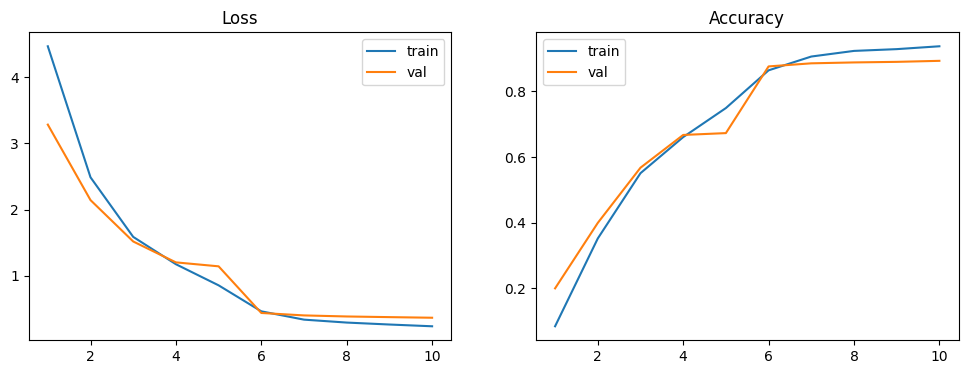

In [24]:
plot_history(history)

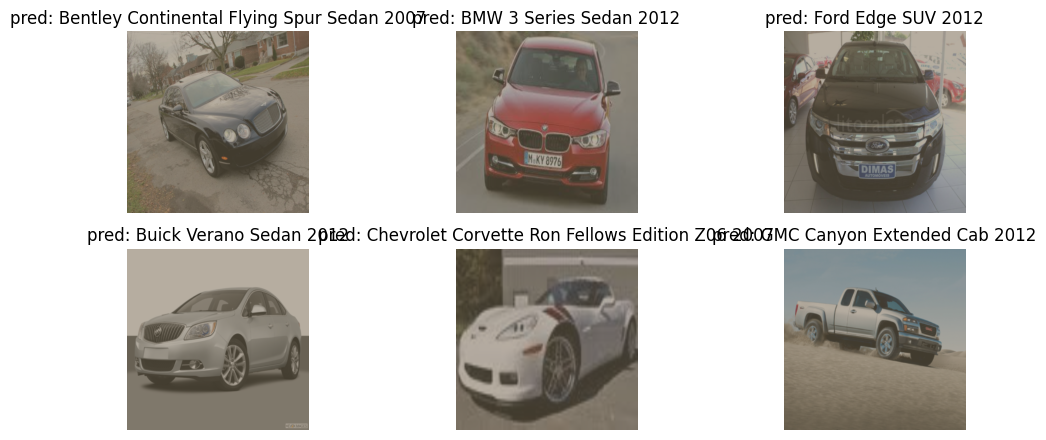

In [25]:
pred_loader = DataLoader(test_dataset, shuffle=True, num_workers=cfg.num_workers)

try:
    visualize_predictions(loaded_model, pred_loader, class_names, device)
except:
    visualize_predictions(model, pred_loader, class_names, device)

## Next steps
- Add a more robust training loop with mixed precision and gradient accumulation for large batches.
- Use `torch.utils.tensorboard` or Weights & Biases for experiment tracking.
- Add stratified splits, cross-validation, or class-imbalance handling.
- Deploy the trained model using TorchScript (`torch.jit.trace`) or export to ONNX for inference in production.